In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
!pip install --upgrade kagglehub
import kagglehub
c7934597_cocotext_v20_path = kagglehub.dataset_download('c7934597/cocotext-v20')

print('Data source import complete.')

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random

VAL_DATA = "/kaggle/cocotext-v20/val.txt"
TRAIN_DATA = "/kaggle/cocotext-v20/train.txt"

In [ ]:


data_dir = os.path.join(c7934597_cocotext_v20_path, 'data')


all_files = os.listdir(data_dir)


image_files = [f for f in all_files if f.endswith(('.png', '.jpg', '.jpeg'))]


num_samples = 5

sampled_image_filenames = random.sample(image_files, k=num_samples)

print(f"Displaying {num_samples} random images:")

for img_filename in sampled_image_filenames:
        img_path = os.path.join(data_dir, img_filename)
        try:
            img = cv.imread(img_path)
            if img is not None:

                img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                print(f"\nTHE SHAPE OF IMAGE '{img_filename}':", img_rgb.shape)
                plt.figure(figsize=(10, 10))
                plt.imshow(img_rgb)
                plt.title(img_filename)
                plt.axis('off')
                plt.show()
            else:
                print(f"Could not load image: {img_filename}. It might be corrupted or not a valid image file.")
        except Exception as e:
            print(f"Error processing image {img_filename}: {e}")

In [5]:
features = {}

for f in os.listdir(data_dir):
    if not f.endswith(('.png', '.jpg', '.jpeg')):
      with open(os.path.join(data_dir, f), 'r') as File:
        content = File.readlines()
        for line in content:
             base_name = os.path.splitext(os.path.basename(f))[0]
             feature = line.split(' ')
             features[base_name] = [float(i) for i in feature[1:]]

In [6]:
imgs_with_features = []
for img in image_files:
  img_path = os.path.join(data_dir, img)
  base_name = os.path.splitext(os.path.basename(img))[0]
  for key, value in features.items():
    if key == base_name:
      imgs_with_features.append([img_path,value])
      break


In [7]:
imgs_with_features[0]

['/root/.cache/kagglehub/datasets/c7934597/cocotext-v20/versions/4/data/442.jpg',
 [0.01015625, 0.6802083333333333, 0.0171875, 0.01875]]

In [8]:
len(imgs_with_features)

17141

In [20]:
import cv2 as cv

def extract_boxes_and_letters(img_with_feature):
    chars = []
    pathOfImage, features = img_with_feature
    img = cv.imread(pathOfImage)

    if img is None:
        raise ValueError(f"Impossible de lire l'image : {pathOfImage}")

    height_img, width_img = img.shape[:2]
    x_center, y_center, width, height = features

    # Convertir coordonnées normalisées en pixels
    w, h = width_img * width, height_img * height
    x, y = x_center * width_img, y_center * height_img

    x_min, y_min = int(x - w/2), int(y - h/2)
    x_max, y_max = int(x + w/2), int(y + h/2)

    # Extraire la région d'intérêt (ROI)
    roi = img[y_min:y_max, x_min:x_max]

    # Convertir en niveaux de gris puis binariser
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)

    # Trouver les contours
    cnts, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    for cnt in cnts:
        area = cv.contourArea(cnt)
        if area < 1000:  # Ignorer les petits contours
            continue




        x, y, w, h = cv.boundingRect(cnt)
        char_roi = roi[y:y+h, x:x+w]

        # Dessiner rectangle sur le caractère
        char = cv.rectangle(roi, (x, y), (x+w, y+h), (0, 255, 0), 1)

        chars.append(char)

    # Retourner l'image avec les boîtes dessinées et la liste des caractères extraits
    return img,roi, chars


Image shape: (488, 500, 3)


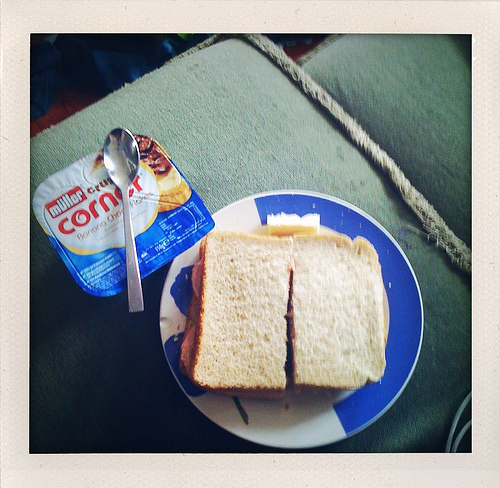

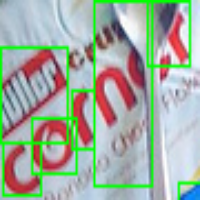

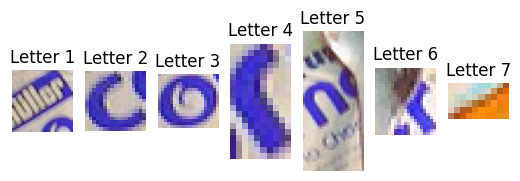

In [22]:
import random
import cv2
from google.colab.patches import cv2_imshow

for sample in random.sample(imgs_with_features, k=1):
    img , word, letters = extract_boxes_and_letters(sample)
    print(f"Image shape: {img.shape}")
    cv2_imshow(img)
    # Zoom the word ROI by resizing (e.g., 500x500)
    word = cv2.resize(word, (200, 200), interpolation=cv2.INTER_LINEAR)
    cv2_imshow(word)

    # Show each letter
    for idx, letter in enumerate(letters):

        # Optionally resize letters if they are too small
        if letter.size > 0: # Check if the letter image is not empty
            plt.subplot(1, len(letters), idx+1)
            plt.title(f"Letter {idx+1}")
            plt.imshow(letter, cmap='gray')
            plt.axis('off')
            #zoomed_letter = cv2.resize(letter, (250, 250), interpolation=cv2.INTER_LINEAR)
            #cv2_imshow(zoomed_letter)
        else:
            print(f"Letter at index {idx} is empty and cannot be displayed.")

In [ ]:
# Install EasyOCR
!pip install easyocr

In [ ]:
import easyocr
import random
from PIL import Image
import matplotlib.pyplot as plt

# Initialize the EasyOCR reader
# You can specify languages like 'en' for English, 'fr' for French, etc.
# This might download language models the first time it's run.
reader = easyocr.Reader(['en'])

Running EasyOCR prediction...


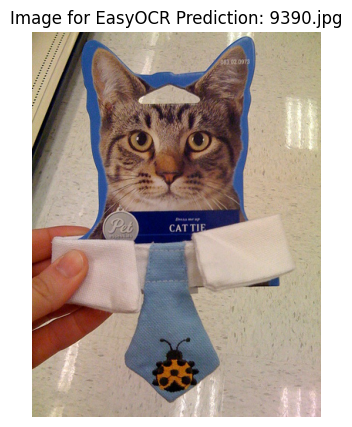

Detected text in 9390.jpg:
  Text: CAT TIF, Confidence: 0.82%, BBox: [[np.int32(177), np.int32(247)], [np.int32(229), np.int32(247)], [np.int32(229), np.int32(263)], [np.int32(177), np.int32(263)]]


In [37]:
print("Running EasyOCR prediction...")

# Select a random image from your dataset
for img_data in random.sample(imgs_with_features, k=1):
    img_path = img_data[0]
    img = Image.open(img_path)

    # Display the image
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.title(f"Image for EasyOCR Prediction: {img_path.split('/')[-1]}")
    plt.axis('off')
    plt.show()

    # Perform OCR
    result = reader.readtext(img_path)

    # Print the detected text and bounding boxes
    print(f"Detected text in {img_path.split('/')[-1]}:")
    for (bbox, text, prob) in result:
        print(f"  Text: {text}, Confidence: {prob:.2f}%, BBox: {bbox}")
